In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Use inspector to view column names for both tables
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
station_columns = inspector.get_columns('station')

print('Measurement table columns')
for col in measurement_columns:
    print(col['name'], col['type'])
    
print('-----------')

print('Station table columns')
for col in station_columns:
    print(col['name'], col['type'])

Measurement table columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
Station table columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

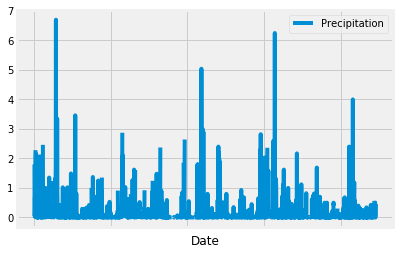

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
l_d_dt = datetime.strptime(latest_date[0], '%Y-%m-%d')
months_ago_12 = l_d_dt - dt.timedelta(days = 365)
m_a_12 = months_ago_12.date()

# Perform a query to retrieve the data and precipitation scores
res = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= m_a_12).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
res_dict = {"Date": [item[0] for item in res], "Precipitation": [item[1] for item in res]}
res_df = pd.DataFrame(res_dict)
res_df.set_index("Date", inplace = True)

# Sort the dataframe by date
res_df.sort_values("Date", ascending = True, inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
res_df.plot()

In [80]:
temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date <= '2011-01-10').all()
temps

[('2010-01-01', 65.0),
 ('2010-01-02', 63.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 76.0),
 ('2010-01-06', 73.0),
 ('2010-01-07', 70.0),
 ('2010-01-08', 64.0),
 ('2010-01-09', 68.0),
 ('2010-01-10', 73.0),
 ('2010-01-11', 64.0),
 ('2010-01-12', 61.0),
 ('2010-01-14', 66.0),
 ('2010-01-15', 65.0),
 ('2010-01-16', 68.0),
 ('2010-01-17', 64.0),
 ('2010-01-18', 72.0),
 ('2010-01-19', 66.0),
 ('2010-01-20', 66.0),
 ('2010-01-21', 69.0),
 ('2010-01-22', 67.0),
 ('2010-01-23', 67.0),
 ('2010-01-24', 71.0),
 ('2010-01-25', 67.0),
 ('2010-01-26', 76.0),
 ('2010-01-27', 68.0),
 ('2010-01-28', 72.0),
 ('2010-01-30', 70.0),
 ('2010-01-31', 67.0),
 ('2010-02-01', 66.0),
 ('2010-02-03', 67.0),
 ('2010-02-04', 69.0),
 ('2010-02-05', 67.0),
 ('2010-02-06', 67.0),
 ('2010-02-07', 64.0),
 ('2010-02-08', 69.0),
 ('2010-02-09', 73.0),
 ('2010-02-11', 73.0),
 ('2010-02-12', 69.0),
 ('2010-02-13', 69.0),
 ('2010-02-14', 69.0),
 ('2010-02-15', 71.0),
 ('2010-02-16', 61.0),
 ('2010-02-17', 69.0),
 ('2010-02-

![precipitation](Images/precipitation.png)

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = res_df.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [81]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.Count(Station.id)).first()
num_stations[0]

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = pd.read_sql_query(\
"SELECT m.station, COUNT(m.station)\
FROM measurement m JOIN station s \
ON m.station = s.station \
GROUP BY m.station \
ORDER BY COUNT(m.station) DESC", engine)

most_active_stations

,station,COUNT(m.station)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
#whcih station has the highest number of observations?
most_active_station = most_active_stations['station'][0]
most_active_station

'USC00519281'

id           int64
station     object
date        object
prcp       float64
tobs       float64
dtype: object

In [51]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_data = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == most_active_station).all()
most_active_station_df = pd.DataFrame({"Station":[item[0] for item in most_active_station_data],\
                                      "Temp": [item[1] for item in most_active_station_data]})
lowest_temp = min(most_active_station_df['Temp'])
highest_temp = max(most_active_station_df['Temp'])
avg_temp = np.mean(most_active_station_df['Temp'])


54.0 85.0 71.66378066378067


Text(0, 0.5, 'Frequency')

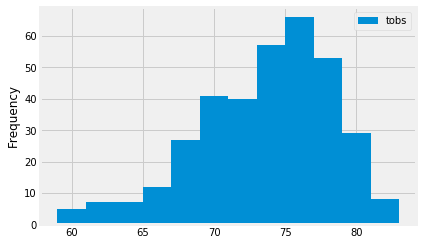

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data_12_mo = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
filter(Measurement.date >= m_a_12).\
filter(Measurement.station == most_active_station).all()

most_active_temp_df = pd.DataFrame({"Date": [item[0] for item in temp_data_12_mo],\
                       "Temp": [item[2] for item in temp_data_12_mo]})

plt.hist(most_active_temp_df['Temp'], label = "tobs", bins = 12)
plt.legend(loc = "best")
plt.ylabel("Frequency")



![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
